In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sentence_transformers import SentenceTransformer
from joblib import Parallel, delayed

Read and Encode the data

In [2]:
df = pd.read_csv("test_data cs 1.csv")

model = SentenceTransformer("all-MiniLM-L6-v2")  
text_embeddings = model.encode(df["text"].astype(str).tolist(), convert_to_numpy=True)
df["text"] = text_embeddings.mean(axis=1)  
screen_name_embeddings = model.encode(df["screen_name"].astype(str).tolist(), convert_to_numpy=True)
df["screen_name"] = screen_name_embeddings.mean(axis=1)  

df["verified"] = df["verified"].replace({"f": 0, "t": 1})


df["created_at"] = pd.to_datetime(df["created_at"], format="%a %b %d %H:%M:%S %Y")
df["hour"] = df["created_at"].dt.hour
df["weekday"] = df["created_at"].dt.weekday
df["month"] = df["created_at"].dt.month
df["year"] = df["created_at"].dt.year
df = df.drop(columns=["created_at"]) 

categorical_cols = ["user_lang", "lang", "time_zone", "location", "source"]
for col in categorical_cols:
    freq_map = df[col].value_counts(normalize=True).to_dict()
    df[col] = df[col].replace(freq_map)

eyewitness_order = {"don't know": -1, "non-eyewitness": 0, "indirect-eyewitness": 1, "direct-eyewitness": 2}
df["label"] = df["label"].replace(eyewitness_order)

for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce') 

num_cols = ["followers_count", "statuses_count", "friends_count", "favourites_count",
            "listed_count", "cred_score", "eye_truth", "compare_text"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Train/test split


In [6]:

X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train, y_train))

GBC using all features

In [4]:
f1_scores = []
auc_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []
mcc_scores = []
fpr_scores = []
fnr_scores = []
best_auc = -float('inf')
best_iteration = 0

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train_resampled, y_train_resampled)
    preds = gbc.predict(X_test)
    probs = gbc.predict_proba(X_test)[:, 1]

    f1 = round(f1_score(y_test, preds, average='weighted', zero_division=1), 6)
    auc = round(roc_auc_score(y_test, probs), 6)
    accuracy = round(accuracy_score(y_test, preds), 6)
    precision = round(precision_score(y_test, preds), 6)
    recall = round(recall_score(y_test, preds), 6)
    
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    specificity = round(tn / (tn + fp), 6)
    mcc = round(matthews_corrcoef(y_test, preds), 6)
    fpr = round(fp / (fp + tn), 6)
    fnr = round(fn / (fn + tp), 6)

    f1_scores.append(f1)
    auc_scores.append(auc)
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    specificity_scores.append(specificity)
    mcc_scores.append(mcc)
    fpr_scores.append(fpr)
    fnr_scores.append(fnr)

    if auc > best_auc:
        best_auc = auc
        best_iteration = fold  

    print(f"Fold {fold}: F1 Score = {f1}, AUC = {auc}, Accuracy = {accuracy}, Precision = {precision}, "
          f"Recall = {recall}, Specificity = {specificity}, MCC = {mcc}, FPR = {fpr}, FNR = {fnr}")

mean_f1 = round(np.mean(f1_scores), 6)
mean_auc = round(np.mean(auc_scores), 6)
mean_accuracy = round(np.mean(accuracy_scores), 6)
mean_precision = round(np.mean(precision_scores), 6)
mean_recall = round(np.mean(recall_scores), 6)
mean_specificity = round(np.mean(specificity_scores), 6)
mean_mcc = round(np.mean(mcc_scores), 6)
mean_fpr = round(np.mean(fpr_scores), 6)
mean_fnr = round(np.mean(fnr_scores), 6)

print("\nMean Metrics across all folds:")
print(f"Mean F1 Score: {mean_f1}")
print(f"Mean AUC Score: {mean_auc}")
print(f"Mean Accuracy: {mean_accuracy}")
print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean Specificity: {mean_specificity}")
print(f"Mean MCC: {mean_mcc}")
print(f"Mean FPR: {mean_fpr}")
print(f"Mean FNR: {mean_fnr}")

print(f"\nBest AUC Score: {best_auc} found at iteration {best_iteration}")

Fold 1: F1 Score = 0.956474, AUC = 0.715152, Accuracy = 0.965, Precision = 0.6, Recall = 0.2, Specificity = 0.994805, MCC = 0.333114, FPR = 0.005195, FNR = 0.8
Fold 2: F1 Score = 0.952933, AUC = 0.841212, Accuracy = 0.96, Precision = 0.428571, Recall = 0.2, Specificity = 0.98961, MCC = 0.274722, FPR = 0.01039, FNR = 0.8
Fold 3: F1 Score = 0.962701, AUC = 0.808571, Accuracy = 0.9675, Precision = 0.625, Recall = 0.333333, Specificity = 0.992208, MCC = 0.441768, FPR = 0.007792, FNR = 0.666667
Fold 4: F1 Score = 0.950256, AUC = 0.900952, Accuracy = 0.96, Precision = 0.4, Recall = 0.133333, Specificity = 0.992208, MCC = 0.214674, FPR = 0.007792, FNR = 0.866667
Fold 5: F1 Score = 0.952943, AUC = 0.807292, Accuracy = 0.9625, Precision = 0.6, Recall = 0.1875, Specificity = 0.994792, MCC = 0.321521, FPR = 0.005208, FNR = 0.8125

Mean Metrics across all folds:
Mean F1 Score: 0.955061
Mean AUC Score: 0.814636
Mean Accuracy: 0.963
Mean Precision: 0.530714
Mean Recall: 0.210833
Mean Specificity: 0.

SelectKbest Algorithm

In [ ]:
X = df.drop("verified", axis=1)
y = df["verified"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(X_train_resampled, y_train_resampled))
gbc = GradientBoostingClassifier(random_state=42)

def evaluate_kbest_kfold(k, X_train, y_train, folds):
    f1_scores = []
    auc_scores = []
    acc_scores = []
    prec_scores = []
    rec_scores = []
    spec_scores = []
    mcc_scores = []
    fpr_scores = []
    fnr_scores = []

    for train_index, test_index in folds:
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        selector = SelectKBest(mutual_info_classif, k=k)
        selector.fit(X_train_fold, y_train_fold)
        selected_X_train = selector.transform(X_train_fold)
        selected_X_test = selector.transform(X_test_fold)

        gbc.fit(selected_X_train, y_train_fold)
        preds = gbc.predict(selected_X_test)
        probs = gbc.predict_proba(selected_X_test)[:, 1]

        f1 = f1_score(y_test_fold, preds, average='weighted', zero_division=1)
        auc = roc_auc_score(y_test_fold, probs)
        acc = accuracy_score(y_test_fold, preds)
        prec = precision_score(y_test_fold, preds, zero_division=1)
        rec = recall_score(y_test_fold, preds, zero_division=1)
        mcc = matthews_corrcoef(y_test_fold, preds)

        tn, fp, fn, tp = confusion_matrix(y_test_fold, preds).ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        f1_scores.append(f1)
        auc_scores.append(auc)
        acc_scores.append(acc)
        prec_scores.append(prec)
        rec_scores.append(rec)
        spec_scores.append(specificity)
        mcc_scores.append(mcc)
        fpr_scores.append(fpr)
        fnr_scores.append(fnr)

    return (
        round(sum(f1_scores) / len(f1_scores), 3),
        round(sum(auc_scores) / len(auc_scores), 3),
        round(sum(acc_scores) / len(acc_scores), 3),
        round(sum(prec_scores) / len(prec_scores), 3),
        round(sum(rec_scores) / len(rec_scores), 3),
        round(sum(spec_scores) / len(spec_scores), 3),
        round(sum(mcc_scores) / len(mcc_scores), 3),
        round(sum(fpr_scores) / len(fpr_scores), 3),
        round(sum(fnr_scores) / len(fnr_scores), 3),
        k
    )

results = Parallel(n_jobs=-1)(
    delayed(evaluate_kbest_kfold)(k, X_train_resampled, y_train_resampled, folds) for k in range(1, 21)
)

f1_score_list, auc_score_list, acc_score_list, prec_score_list, rec_score_list, spec_score_list, mcc_score_list, fpr_score_list, fnr_score_list, feature_counts = zip(*results)

print("\n--- Performance Metrics Across Feature Selection Values ---")
for i in range(len(feature_counts)):
    print(f"K={feature_counts[i]}")
    print(f"  F1 Score: {f1_score_list[i]}")
    print(f"  AUC: {auc_score_list[i]}")
    print(f"  Accuracy: {acc_score_list[i]}")
    print(f"  Precision: {prec_score_list[i]}")
    print(f"  Recall: {rec_score_list[i]}")
    print(f"  Specificity: {spec_score_list[i]}")
    print(f"  MCC: {mcc_score_list[i]}")
    print(f"  FPR: {fpr_score_list[i]}")
    print(f"  FNR: {fnr_score_list[i]}")
    print("-" * 40)

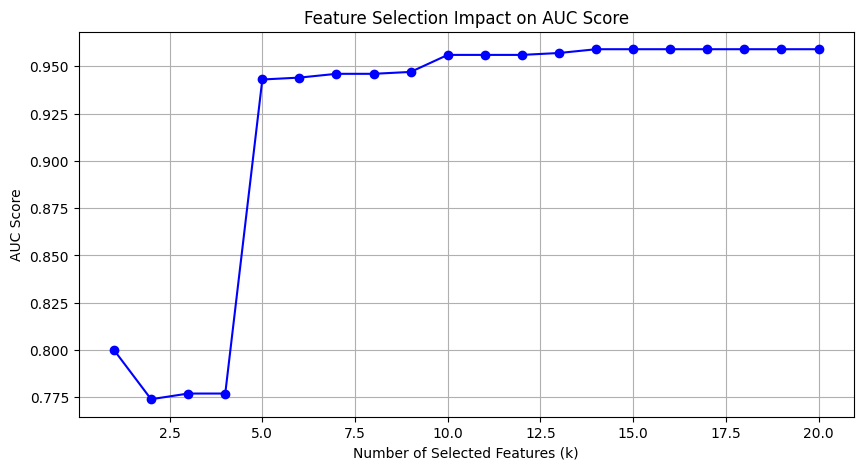

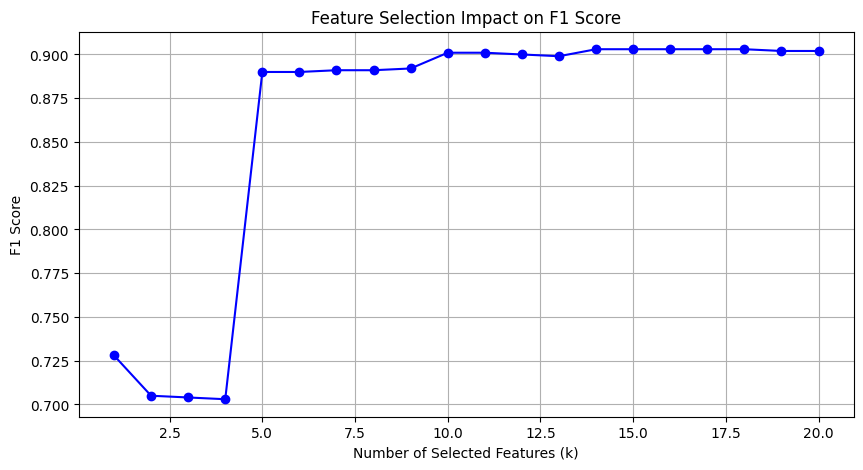

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(feature_counts, auc_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("AUC Score")
plt.title("Feature Selection Impact on AUC Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(feature_counts, f1_score_list, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Selected Features (k)")
plt.ylabel("F1 Score")
plt.title("Feature Selection Impact on F1 Score")
plt.grid(True)
plt.show()

Hybrid Squirrel Dragonfly Algorithm

In [ ]:
X_train_V3, X_test_V3, y_train_V3, y_test_V3 = (
    X_train.copy(),
    X_test.copy(),
    y_train.copy(),
    y_test.copy()
)


n_features = X_train_V3.shape[1]

class HSDSO:
    def __init__(self, obj_function, dim, bounds, pop_size=5, max_iter=1):
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.population = np.random.uniform(self.bounds[:, 0], self.bounds[:, 1], (pop_size, dim))
        self.best_solution = self.population[0].copy()  
        self.best_fitness = float('-inf')
        self.best_auc = float('-inf')
        self.best_metrics = None 
        self.best_iteration = 0 
        self.C3 = 0.5  

    def update_position_ssa(self, squirrel, best_squirrel):
        seasonal_factor = np.random.uniform(0, 1)
        return squirrel + seasonal_factor * (best_squirrel - squirrel)
    
    def update_position_da(self, dragonfly, best_dragonfly):
        separation = np.random.uniform(-1, 1, self.dim)
        alignment = (best_dragonfly - dragonfly) / 2
        cohesion = best_dragonfly - dragonfly
        return dragonfly + separation + alignment + cohesion
    
    def optimize(self):
        for iteration in range(self.max_iter):
            fitness_values = np.array([self.obj_function(ind) for ind in self.population])
            best_idx = np.argmax(fitness_values[:, 1])  

            mean_f1, mean_auc = fitness_values[best_idx]
            
            if mean_auc > self.best_auc:
                self.best_auc = mean_auc
                self.best_solution = self.population[best_idx]
                selected_mask = self.best_solution[2:] > 0.5
                self.best_metrics = {
                    'f1': mean_f1,
                    'auc': mean_auc,
                }
                self.best_iteration = iteration + 1  
            
            for i in range(self.pop_size):
                if np.random.uniform(0, 1) < self.C3:
                    self.population[i] = self.update_position_ssa(self.population[i], self.best_solution)
                else:
                    self.population[i] = self.update_position_da(self.population[i], self.best_solution)
                self.population[i] = np.clip(self.population[i], self.bounds[:, 0], self.bounds[:, 1])
        
        print(f"Best AUC score found at iteration {self.best_iteration}: {self.best_auc:.4f}")
        print(f"Best Metrics for AUC Score: {self.best_metrics}")
        return self.best_solution, self.best_fitness, self.best_auc, self.best_metrics


def objective_function(params):
    learning_rate = params[0]
    n_estimators = int(params[1])
    feature_mask_params = params[2:]
    threshold = 0.5
    selected_mask = feature_mask_params > threshold

    if not np.any(selected_mask):
        selected_mask = np.ones_like(feature_mask_params, dtype=bool)
    selected_feature_names = X_train_V3.columns[selected_mask]
    
    print("Selected features for this evaluation:", list(selected_feature_names))
    X_selected = X_train_V3[selected_feature_names]
    
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_V3)
    X_resampled = pd.DataFrame(X_resampled, columns=selected_feature_names).reset_index(drop=True)
    y_resampled = pd.Series(y_resampled).reset_index(drop=True)
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    auc_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    specificity_scores = []
    mcc_scores = []
    fpr_scores = []
    fnr_scores = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_resampled, y_resampled), start=1):
        X_train_fold, X_test_fold = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
        y_train_fold, y_test_fold = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]
        
        gbc = GradientBoostingClassifier(learning_rate=learning_rate, n_estimators=n_estimators, random_state=42)
        gbc.fit(X_train_fold, y_train_fold)
        preds = gbc.predict(X_test_fold)
        probs = gbc.predict_proba(X_test_fold)[:, 1]
        
        f1 = f1_score(y_test_fold, preds, average='weighted', zero_division=1)
        auc = roc_auc_score(y_test_fold, probs)
        accuracy = accuracy_score(y_test_fold, preds)
        precision = precision_score(y_test_fold, preds)
        recall = recall_score(y_test_fold, preds)
        tn, fp, fn, tp = confusion_matrix(y_test_fold, preds).ravel()
        specificity = tn / (tn + fp)
        mcc = matthews_corrcoef(y_test_fold, preds)
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)

        f1_scores.append(f1)
        auc_scores.append(auc)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        specificity_scores.append(specificity)
        mcc_scores.append(mcc)
        fpr_scores.append(fpr)
        fnr_scores.append(fnr)
        
        print(f"Fold {fold}: F1 Score = {f1:.4f}, AUC = {auc:.4f}, Accuracy = {accuracy:.4f}, Precision = {precision:.4f}, "
              f"Recall = {recall:.4f}, Specificity = {specificity:.4f}, MCC = {mcc:.4f}, FPR = {fpr:.4f}, FNR = {fnr:.4f}")
    
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(auc_scores)
    mean_accuracy = np.mean(accuracy_scores)
    mean_precision = np.mean(precision_scores)
    mean_recall = np.mean(recall_scores)
    mean_specificity = np.mean(specificity_scores)
    mean_mcc = np.mean(mcc_scores)
    mean_fpr = np.mean(fpr_scores)
    mean_fnr = np.mean(fnr_scores)
    
    print("Mean F1 Score:", mean_f1)
    print("Mean AUC Score:", mean_auc)
    print("Mean Accuracy:", mean_accuracy)
    print("Mean Precision:", mean_precision)
    print("Mean Recall:", mean_recall)
    print("Mean Specificity:", mean_specificity)
    print("Mean MCC:", mean_mcc)
    print("Mean FPR:", mean_fpr)
    print("Mean FNR:", mean_fnr)
    
    return mean_f1, mean_auc 

bounds_hyper = np.array([[0.01, 0.2], [50, 300]])
bounds_features = np.tile(np.array([[0, 1]]), (n_features, 1))
bounds = np.concatenate([bounds_hyper, bounds_features], axis=0)

start_time = time.time()

hs_dso = HSDSO(obj_function=objective_function, dim=2 + n_features, bounds=bounds, pop_size=5, max_iter=3)
best_params, best_f1, best_auc, best_metrics = hs_dso.optimize()

end_time = time.time()
elapsed_time = end_time - start_time

print("\n--- Optimization Results ---")
print(f"Optimized Learning Rate: {best_params[0]:.4f}")
print(f"Optimized n_estimators: {int(best_params[1])}")
print(f"Best AUC Score: {best_auc:.6f}")
print(f"Best Metrics: {best_metrics}")
print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")


Whale Optimization Algorithm

In [ ]:
class WhaleOptimization:
    def __init__(self, X, y, num_whales=10, max_iter=5, k_folds=5, num_jobs=-1):
        self.X = X
        self.y = y
        self.num_whales = num_whales
        self.max_iter = max_iter
        self.num_features = X.shape[1]
        self.k_folds = k_folds
        self.num_jobs = num_jobs  
        self.whales = np.random.randint(0, 2, (self.num_whales, self.num_features))  
        self.best_whale = self.whales[0].copy()  
        self.best_score = -1
        
        smote = SMOTE(random_state=42)
        self.X_resampled, self.y_resampled = smote.fit_resample(self.X, self.y)

    def fitness(self, whale, X_train, X_test, y_train, y_test):
        selected_features = np.where(whale == 1)[0]
        if len(selected_features) == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0, 0  

        X_train_fs = X_train.iloc[:, selected_features]
        X_test_fs = X_test.iloc[:, selected_features]

        model = GradientBoostingClassifier(random_state=42)
        model.fit(X_train_fs, y_train)
        y_pred_proba = model.predict_proba(X_test_fs)[:, 1]

        auc_score = roc_auc_score(y_test, y_pred_proba)
        y_pred = model.predict(X_test_fs)
        accuracy = accuracy_score(y_test, y_pred)

        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred, zero_division=1)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        mcc = matthews_corrcoef(y_test, y_pred)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        return auc_score, accuracy, f1, precision, recall, specificity, mcc, fpr, fnr

    def optimize(self):
        skf = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        best_auc = -float('inf')
        best_iteration = 0
        best_metrics = None

        for iteration in range(self.max_iter):
            for train_idx, test_idx in skf.split(self.X_resampled, self.y_resampled):
                X_train, X_test = self.X_resampled.iloc[train_idx], self.X_resampled.iloc[test_idx]
                y_train, y_test = self.y_resampled.iloc[train_idx], self.y_resampled.iloc[test_idx]

                results = Parallel(n_jobs=self.num_jobs)(
                    delayed(self.fitness)(self.whales[i], X_train, X_test, y_train, y_test)
                    for i in range(self.num_whales)
                )

                for i, (auc_score, accuracy, f1, precision, recall, specificity, mcc, fpr, fnr) in enumerate(results):
                    if auc_score > best_auc:
                        best_auc = auc_score
                        best_iteration = iteration
                        best_metrics = (accuracy, f1, precision, recall, specificity, mcc, fpr, fnr)
                        self.best_whale = self.whales[i].copy() 
        
                    A = 2 * np.random.rand() - 1 
                    C = 2 * np.random.rand() 
                    p = np.random.rand()
                    l = np.random.uniform(-1, 1)  
                    
                    if p < 0.5:
                        if abs(A) < 1:
                            self.whales[i] = self.best_whale + A * (self.best_whale - self.whales[i])
                        else:
                            rand_whale = self.whales[np.random.randint(0, self.num_whales)]
                            D = abs(C * rand_whale - self.whales[i])
                            self.whales[i] = rand_whale - A * D
                    else:
                        D = abs(self.best_whale - self.whales[i])
                        self.whales[i] = D * np.exp(l) * np.cos(2 * np.pi * l) + self.best_whale
                    
                    self.whales[i] = np.clip(self.whales[i], 0, 1)  
                    self.whales[i] = (self.whales[i] > 0.5).astype(int)  

        return self.best_whale, best_auc, best_metrics

start_time = time.time()

woa = WhaleOptimization(X, y, num_whales=10, max_iter=5, k_folds=5, num_jobs=-1)
best_features, best_auc, best_metrics = woa.optimize()

end_time = time.time()
elapsed_time = end_time - start_time

print("Selected Features:", np.where(best_features == 1)[0])
print("Best AUC Score:", best_auc)
print("Best Metrics for the Best AUC Iteration:")
print(f"Accuracy: {best_metrics[0]:.6f}")
print(f"F1 Score: {best_metrics[1]:.6f}")
print(f"Precision: {best_metrics[2]:.6f}")
print(f"Recall: {best_metrics[3]:.6f}")
print(f"Specificity: {best_metrics[4]:.6f}")
print(f"MCC: {best_metrics[5]:.6f}")
print(f"FPR: {best_metrics[6]:.6f}")
print(f"FNR: {best_metrics[7]:.6f}")

print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")


Selected Features: [ 0  1  2  4  5  6  8  9 10 11 13 15 17 18 19]
Best AUC Score: 0.9520901655060422
Best Metrics for the Best AUC Iteration:
Accuracy: 0.892756
F1 Score: 0.891549
Precision: 0.997778
Recall: 0.787265
Specificity: 0.998247
MCC: 0.803601
FPR: 0.001753
FNR: 0.212735


Horse Heard Optimization Algorithm

In [ ]:
class HorseHerdOptimization:
    def __init__(self, X, y, num_horses=10, max_iter=5, k_folds=5, num_jobs=-1):
        self.X = X
        self.y = y
        self.num_horses = num_horses
        self.max_iter = max_iter
        self.num_features = X.shape[1]
        self.k_folds = k_folds
        self.num_jobs = num_jobs  
        self.horses = np.random.randint(0, 2, (self.num_horses, self.num_features))  
        self.best_horse = self.horses[0].copy()  
        self.best_score = -1
        
        smote = SMOTE(random_state=42)
        self.X_resampled, self.y_resampled = smote.fit_resample(self.X, self.y)

    def fitness(self, horse, X_train, X_test, y_train, y_test):
        selected_features = np.where(horse == 1)[0]
        if len(selected_features) == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0, 0 

        X_train_fs = X_train.iloc[:, selected_features]
        X_test_fs = X_test.iloc[:, selected_features]

        model = GradientBoostingClassifier(random_state=42)
        model.fit(X_train_fs, y_train)
        y_pred_proba = model.predict_proba(X_test_fs)[:, 1]

        auc_score = roc_auc_score(y_test, y_pred_proba)
        y_pred = model.predict(X_test_fs)
        accuracy = accuracy_score(y_test, y_pred)

        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred, zero_division=1)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        mcc = matthews_corrcoef(y_test, y_pred)
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0

        return auc_score, accuracy, f1, precision, recall, specificity, mcc, fpr, fnr

    def optimize(self):
        skf = StratifiedKFold(n_splits=self.k_folds, shuffle=True, random_state=42)
        best_auc = -float('inf')
        best_iteration = 0
        best_metrics = None

        for iteration in range(self.max_iter):
            for train_idx, test_idx in skf.split(self.X_resampled, self.y_resampled):
                X_train, X_test = self.X_resampled.iloc[train_idx], self.X_resampled.iloc[test_idx]
                y_train, y_test = self.y_resampled.iloc[train_idx], self.y_resampled.iloc[test_idx]

                results = Parallel(n_jobs=self.num_jobs)(
                    delayed(self.fitness)(self.horses[i], X_train, X_test, y_train, y_test)
                    for i in range(self.num_horses)
                )

                for i, (auc_score, accuracy, f1, precision, recall, specificity, mcc, fpr, fnr) in enumerate(results):
                    if auc_score > best_auc:
                        best_auc = auc_score
                        best_iteration = iteration
                        best_metrics = (accuracy, f1, precision, recall, specificity, mcc, fpr, fnr)
                        self.best_horse = self.horses[i].copy()  

                    leader = self.best_horse.copy()
                    rand_horse = self.horses[np.random.randint(0, self.num_horses)]
                    exploration_factor = np.random.uniform(0, 1)
                    self.horses[i] = leader + exploration_factor * (rand_horse - leader)
                    self.horses[i] = np.clip(self.horses[i], 0, 1)  
                    self.horses[i] = (self.horses[i] > 0.5).astype(int)  

        return self.best_horse, best_auc, best_metrics

start_time = time.time()

hoa = HorseHerdOptimization(X, y, num_horses=10, max_iter=5, k_folds=5, num_jobs=-1)
best_features, best_auc, best_metrics = hoa.optimize()

end_time = time.time()
elapsed_time = end_time - start_time

print("Selected Features:", np.where(best_features == 1)[0])
print("Best AUC Score:", best_auc)
print("Best Metrics for the Best AUC Iteration:")
print(f"Accuracy: {best_metrics[0]:.6f}")
print(f"F1 Score: {best_metrics[1]:.6f}")
print(f"Precision: {best_metrics[2]:.6f}")
print(f"Recall: {best_metrics[3]:.6f}")
print(f"Specificity: {best_metrics[4]:.6f}")
print(f"MCC: {best_metrics[5]:.6f}")
print(f"FPR: {best_metrics[6]:.6f}")
print(f"FNR: {best_metrics[7]:.6f}")
print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")


Selected Features: [ 1  2  3  5  6  7  8  9 10 13 14 16]
Best AUC Score: 0.9500356220610571
Best Metrics for the Best AUC Iteration:
Accuracy: 0.892475
F1 Score: 0.891265
Precision: 0.997386
Recall: 0.787007
Specificity: 0.997938
MCC: 0.803015
FPR: 0.002062
FNR: 0.212993


Binary Particle Swarm Optimization Algorithm

In [ ]:
class BinaryPSOWithMutation:
    def __init__(self, X_train, X_test, y_train, y_test, num_particles=10, max_iter=20, mutation_rate=0.1, num_folds=5):
        self.X_train = X_train  
        self.X_test = X_test    
        self.y_train = y_train
        self.y_test = y_test
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.num_features = X_train.shape[1]
        self.mutation_rate = mutation_rate
        self.num_folds = num_folds 
        self.particles = np.random.randint(0, 2, (self.num_particles, self.num_features))  
        self.best_particle = None
        self.best_score = -1

    def fitness(self, particle):
        selected_features = np.where(particle == 1)[0]
        if len(selected_features) == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0  

        X_train_fs = self.X_train.iloc[:, selected_features]
        y_train_fs = self.y_train
        
        smote = SMOTE(random_state=42)
        X_train_fs, y_train_fs = smote.fit_resample(X_train_fs, y_train_fs)

        skf = StratifiedKFold(n_splits=self.num_folds, shuffle=True, random_state=42)
        auc_scores = []
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        mcc_scores = []
        specificity_scores = []

        for train_index, val_index in skf.split(X_train_fs, y_train_fs):
            X_fold_train, X_fold_val = X_train_fs.iloc[train_index], X_train_fs.iloc[val_index]
            y_fold_train, y_fold_val = y_train_fs.iloc[train_index], y_train_fs.iloc[val_index]

            model = GradientBoostingClassifier(random_state=42)
            model.fit(X_fold_train, y_fold_train)

            y_pred = model.predict(X_fold_val)
            y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
            auc_score = roc_auc_score(y_fold_val, y_pred_proba)
            accuracy = accuracy_score(y_fold_val, y_pred)
            precision = precision_score(y_fold_val, y_pred)
            recall = recall_score(y_fold_val, y_pred)
            f1 = f1_score(y_fold_val, y_pred)
            mcc = matthews_corrcoef(y_fold_val, y_pred)
            tn, fp, fn, tp = confusion_matrix(y_fold_val, y_pred).ravel()
            specificity = tn / (tn + fp)

            auc_scores.append(auc_score)
            accuracy_scores.append(accuracy)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)
            mcc_scores.append(mcc)
            specificity_scores.append(specificity)

        avg_auc = np.mean(auc_scores)
        avg_accuracy = np.mean(accuracy_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        avg_f1 = np.mean(f1_scores)
        avg_mcc = np.mean(mcc_scores)
        avg_specificity = np.mean(specificity_scores)

        return avg_auc, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_mcc, avg_specificity

    def mutate(self, particle):
        mutation_mask = np.random.rand(self.num_features) < self.mutation_rate
        particle[mutation_mask] = 1 - particle[mutation_mask]
        return particle

    def optimize(self):
        best_accuracy = -1
        
        for iter_num in range(self.max_iter):
            fitness_results = Parallel(n_jobs=-1)(delayed(self.fitness)(self.mutate(self.particles[i])) for i in range(self.num_particles))

            for i, (auc_score, accuracy, precision, recall, f1, mcc, specificity) in enumerate(fitness_results):
                if auc_score > self.best_score:
                    self.best_score = auc_score
                    self.best_particle = self.particles[i].copy()
                    best_accuracy = accuracy
                    best_precision = precision
                    best_recall = recall
                    best_f1 = f1
                    best_mcc = mcc
                    best_specificity = specificity

                A = 2 * np.random.rand() - 1  
                C = 2 * np.random.rand()      
                p = np.random.rand()
                l = np.random.uniform(-1, 1)  

                if p < 0.5:
                    if abs(A) < 1:
                        self.particles[i] = self.best_particle + A * (self.best_particle - self.particles[i])
                    else:
                        rand_particle = self.particles[np.random.randint(0, self.num_particles)]
                        D = abs(C * rand_particle - self.particles[i])
                        self.particles[i] = rand_particle - A * D
                else:
                    D = abs(self.best_particle - self.particles[i])
                    self.particles[i] = D * np.exp(l) * np.cos(2 * np.pi * l) + self.best_particle

                self.particles[i] = np.clip(self.particles[i], 0, 1)
                self.particles[i] = (self.particles[i] > 0.5).astype(int)

        selected_features = np.where(self.best_particle == 1)[0]
        return selected_features, self.best_score, best_accuracy, best_precision, best_recall, best_f1, best_mcc, best_specificity

start_time = time.time()

b_pso = BinaryPSOWithMutation(X_train, X_test, y_train, y_test, num_particles=5, max_iter=10, mutation_rate=0.1, num_folds=3)
best_features, best_auc, best_accuracy, best_precision, best_recall, best_f1, best_mcc, best_specificity = b_pso.optimize()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Selected Features: {best_features}")
print(f"Best AUC Score: {best_auc}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Precision: {best_precision}")
print(f"Best Recall: {best_recall}")
print(f"Best F1 Score: {best_f1}")
print(f"Best MCC: {best_mcc}")
print(f"Best Specificity: {best_specificity}")
print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")

Selected Features: [ 2  4  5  6  8  9 12 17 18 19]
Best AUC Score: 0.9721981098888297
Best Accuracy: 0.9290028393760624
Best Precision: 0.9999656438867692
Best Recall: 0.8580351989969905
Best F1 Score: 0.923576153364702
Best MCC: 0.8667844862848032
Best Specificity: 0.9999705373255114


Grey Sail Fish Optimization Algorithm

In [ ]:
class GreySailFishOptimization:
    def __init__(self, X_train, X_test, y_train, y_test, n_particles=30, max_iter=100, mutation_rate=0.1, w1=0.5, w2=0.5, n_jobs=-1):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.n_features = X_train.shape[1]
        self.n_particles = n_particles
        self.max_iter = max_iter
        self.mutation_rate = mutation_rate
        self.w1 = w1
        self.w2 = w2
        self.n_jobs = n_jobs

        smote = SMOTE(random_state=42)
        self.X_train_resampled, self.y_train_resampled = smote.fit_resample(self.X_train, self.y_train)

        self.positions = np.random.randint(0, 2, (self.n_particles, self.n_features))
        self.velocities = np.random.rand(self.n_particles, self.n_features)
        self.best_positions = np.copy(self.positions)
        self.best_scores = np.zeros(self.n_particles)
        self.global_best_position = None
        self.global_best_score = float('-inf')
        self.global_best_metrics = {
            'auc': 0, 'accuracy': 0, 'precision': 0, 'recall': 0, 
            'f1': 0, 'mcc': 0, 'specificity': 0
        }

    def fitness_function(self, position):
        selected_features = np.where(position == 1)[0]
        if len(selected_features) == 0:
            return 0, 0, 0, 0, 0, 0, 0, 0  

        X = self.X_train_resampled.iloc[:, selected_features]
        y = self.y_train_resampled

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        auc_scores, accuracy_scores, precision_scores, recall_scores = [], [], [], []
        f1_scores, mcc_scores, specificity_scores = [], [], []

        for train_idx, val_idx in skf.split(X, y):
            X_fold_train = X.iloc[train_idx]
            X_fold_val = X.iloc[val_idx]
            y_fold_train = y.iloc[train_idx] if hasattr(y, 'iloc') else y[train_idx]
            y_fold_val = y.iloc[val_idx] if hasattr(y, 'iloc') else y[val_idx]

            clf = GradientBoostingClassifier(random_state=42)
            clf.fit(X_fold_train, y_fold_train)

            y_pred_proba = clf.predict_proba(X_fold_val)[:, 1]
            y_pred = clf.predict(X_fold_val)

            auc_scores.append(roc_auc_score(y_fold_val, y_pred_proba))
            accuracy_scores.append(accuracy_score(y_fold_val, y_pred))
            precision_scores.append(precision_score(y_fold_val, y_pred, zero_division=1))
            recall_scores.append(recall_score(y_fold_val, y_pred, zero_division=1))
            f1_scores.append(f1_score(y_fold_val, y_pred, zero_division=1))
            mcc_scores.append(matthews_corrcoef(y_fold_val, y_pred))
            tn, fp, fn, tp = confusion_matrix(y_fold_val, y_pred).ravel()
            specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
            specificity_scores.append(specificity)

        avg_auc = np.mean(auc_scores)
        avg_acc = np.mean(accuracy_scores)
        avg_precision = np.mean(precision_scores)
        avg_recall = np.mean(recall_scores)
        avg_f1 = np.mean(f1_scores)
        avg_mcc = np.mean(mcc_scores)
        avg_specificity = np.mean(specificity_scores)

        fitness = self.w1 * avg_auc + self.w2 * avg_acc
        return fitness, avg_auc, avg_acc, avg_precision, avg_recall, avg_f1, avg_mcc, avg_specificity

    def update_position(self, i):
        alpha = 2 * np.random.rand() - 1
        beta = 2 * np.random.rand() - 1
        delta = 2 * np.random.rand() - 1

        sailfish_position = self.best_positions[i]
        rand_particle = self.positions[np.random.randint(0, self.n_particles)]

        self.velocities[i] = (self.velocities[i] + 
                              alpha * (self.global_best_position - self.positions[i]) + 
                              beta * (sailfish_position - self.positions[i]))
        self.positions[i] = np.clip(self.positions[i] + self.velocities[i], 0, 1)

        self.positions[i] = (self.positions[i] * np.exp(delta) * np.cos(2 * np.pi * delta) + 
                             self.global_best_position)
        self.positions[i] = np.clip(self.positions[i], 0, 1)
        self.positions[i] = (self.positions[i] > 0.5).astype(int)

        self.mutation(i)

    def mutation(self, i):
        mutation_mask = np.random.rand(self.n_features) < self.mutation_rate
        self.positions[i][mutation_mask] = 1 - self.positions[i][mutation_mask]

    def optimize(self):
        for iteration in range(self.max_iter):
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.fitness_function)(self.positions[i])
                for i in range(self.n_particles)
            )

            for i, (fitness, auc, acc, prec, rec, f1, mcc, spec) in enumerate(results):
                if fitness > self.best_scores[i]:
                    self.best_scores[i] = fitness
                    self.best_positions[i] = self.positions[i].copy()

                if fitness > self.global_best_score:
                    self.global_best_score = fitness
                    self.global_best_position = self.positions[i].copy()
                    self.global_best_metrics = {
                        'auc': auc, 'accuracy': acc, 'precision': prec, 'recall': rec, 
                        'f1': f1, 'mcc': mcc, 'specificity': spec
                    }

                self.update_position(i)

            print(f"Iteration {iteration+1}/{self.max_iter} - Best Fitness: {self.global_best_score:.4f} | "
                  f"Best AUC: {self.global_best_metrics['auc']:.4f} | Best Accuracy: {self.global_best_metrics['accuracy']:.4f}")

        best_feature_indices = np.where(self.global_best_position == 1)[0]
        return (best_feature_indices, self.global_best_score, self.global_best_metrics['auc'], 
                self.global_best_metrics['accuracy'], self.global_best_metrics['precision'], 
                self.global_best_metrics['recall'], self.global_best_metrics['f1'], 
                self.global_best_metrics['mcc'], self.global_best_metrics['specificity'])

    def evaluate_on_test(self):
        selected_features = np.where(self.global_best_position == 1)[0]
        if len(selected_features) == 0:
            return 0, 0, 0, 0, 0, 0, 0

        X_test_selected = self.X_test.iloc[:, selected_features]
        clf = GradientBoostingClassifier(random_state=42)
        clf.fit(self.X_train.iloc[:, selected_features], self.y_train)
        y_pred_proba = clf.predict_proba(X_test_selected)[:, 1]
        y_pred = clf.predict(X_test_selected)

        test_auc = roc_auc_score(self.y_test, y_pred_proba)
        test_accuracy = accuracy_score(self.y_test, y_pred)
        test_precision = precision_score(self.y_test, y_pred, zero_division=1)
        test_recall = recall_score(self.y_test, y_pred, zero_division=1)
        test_f1 = f1_score(self.y_test, y_pred, zero_division=1)
        test_mcc = matthews_corrcoef(self.y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred).ravel()
        test_specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

        return test_auc, test_accuracy, test_precision, test_recall, test_f1, test_mcc, test_specificity

start_time = time.time()

gsfo = GreySailFishOptimization(X_train, X_test, y_train, y_test, n_particles=5, max_iter=5, mutation_rate=0.1, n_jobs=-1)
best_features, best_score, best_auc, best_accuracy, best_precision, best_recall, best_f1, best_mcc, best_specificity = gsfo.optimize()

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Selected Features: {best_features}")
print(f"Best AUC Score: {best_auc}")
print(f"Best Accuracy: {best_accuracy}")
print(f"Best Precision: {best_precision}")
print(f"Best Recall: {best_recall}")
print(f"Best F1 Score: {best_f1}")
print(f"Best MCC: {best_mcc}")
print(f"Best Specificity: {best_specificity}")
print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")

Cattle Corral Algorithm

In [ ]:
def weighted_correlation(x, y, weights=None):
    """Computes the weighted Pearson correlation coefficient."""
    if weights is None:
        weights = np.ones_like(x) 
    weights = np.array(weights) / np.sum(weights)  

    mean_x = np.sum(weights * x)
    mean_y = np.sum(weights * y)

    num = np.sum(weights * (x - mean_x) * (y - mean_y))
    denom_x = np.sqrt(np.sum(weights * (x - mean_x) ** 2))
    denom_y = np.sqrt(np.sum(weights * (y - mean_y) ** 2))

    return num / (denom_x * denom_y) if denom_x > 0 and denom_y > 0 else 0  

y = df["verified"].astype(int) 

correlations = Parallel(n_jobs=-1)(
    delayed(weighted_correlation)(df[col].astype(float), y) for col in df.columns if col != "verified"
)

mutual_infos = Parallel(n_jobs=-1)(
    delayed(mutual_info_classif)(df[[col]], y.values.ravel(), discrete_features=False) for col in df.columns if col != "verified"
)

mutual_infos = [mi[0] for mi in mutual_infos]  

correlations_dict = dict(zip(df.columns[df.columns != "verified"], correlations))
mutual_infos_dict = dict(zip(df.columns[df.columns != "verified"], mutual_infos))


result_df = pd.DataFrame({"Weighted Correlation": correlations_dict, "Mutual Information": mutual_infos_dict})

def min_max_scale(series):
    min_val, max_val = series.min(), series.max()
    return (series - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(series)

result_df["Normalized Correlation"] = min_max_scale(result_df["Weighted Correlation"])
result_df["Normalized MI"] = min_max_scale(result_df["Mutual Information"])

w_c = 0.5  
w_m = 0.5  

result_df["Combined Score"] = w_c * result_df["Normalized Correlation"] + w_m * result_df["Normalized MI"]

result_df["Combined Score"] += 1e-6 * np.random.rand(len(result_df))

column_mapping = {col: f"{result_df.loc[col, 'Combined Score']:.4f}_{col}" for col in result_df.index}

df_renamed = df.rename(columns=column_mapping)

df_sorted = df_renamed.reindex(sorted(df_renamed.columns, 
                                      key=lambda x: float(x.split('_')[0]) if x != "verified" else float("-inf"), 
                                      reverse=True), axis=1)

X = df_sorted.drop("verified", axis=1)
y = df_sorted["verified"]
X_train_V3, X_test_V3, y_train_V3, y_test_V3 = train_test_split(X, y, test_size=0.4, shuffle=True, stratify=y, random_state=42)
n_features = 20

class CattleCorral:
    def __init__(self, obj_function, dim, bounds, sorted_df, pop_size=10, max_iter=10, patience=3):
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = bounds
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.patience = patience  
        self.sorted_df = sorted_df
        self.best_solution = None
        self.best_fitness = float('-inf')
        self.best_auc = float('-inf')
        self.best_features = None
        self.C3 = 0.5  

        self.population = self.initialize_population()

    def initialize_population(self):
        """Initialize population with bias towards top-ranked features."""
        population = np.zeros((self.pop_size, self.dim))
        population[:, :4] = np.random.uniform(self.bounds[:4, 0], self.bounds[:4, 1], (self.pop_size, 4))
        
        n_features = self.dim - 4
        feature_probabilities = self.compute_feature_probabilities(n_features)
        for i in range(self.pop_size):
            feature_mask = np.random.uniform(0, 1, n_features) < feature_probabilities
            population[i, 4:] = feature_mask.astype(float)
        return population

    def compute_feature_probabilities(self, n_features):
        """Compute selection probabilities for features."""
        max_prob = 0.9
        min_prob = 0.1
        return np.linspace(max_prob, min_prob, n_features)

    def update_position_egret(self, egret, best_egret):
        """Egret update with adaptive jump factor."""
        jump_factor = np.random.uniform(0, 0.7) 
        new_position = egret + jump_factor * (best_egret - egret)
        exploration_factor = np.random.uniform(-0.3, 0.3, self.dim) 
        new_position += exploration_factor
        return np.clip(new_position, self.bounds[:, 0], self.bounds[:, 1])

    def update_position_fly(self, fly, best_fly):
        """Fly update with refined local search."""
        local_move = np.random.uniform(-0.15, 0.15, self.dim)  
        new_position = fly + local_move
        attraction_factor = 0.4  
        new_position += attraction_factor * (best_fly - fly)
        return np.clip(new_position, self.bounds[:, 0], self.bounds[:, 1])

    def optimize(self):
        no_improvement_count = 0
        best_metrics = None

        for iteration in range(self.max_iter):
            fitness_values = np.array(Parallel(n_jobs=-1)(delayed(self.obj_function)(ind) for ind in self.population))
            best_idx = np.argmax(fitness_values[:, 1]) 

            best_fitness, best_auc, best_acc, best_precision, best_fpr, best_fnr, best_mcc = fitness_values[best_idx]

            if best_auc > self.best_auc:
                self.best_fitness, self.best_auc = best_fitness, best_auc
                self.best_solution = self.population[best_idx]
                feature_mask = self.best_solution[4:]  
                selected_features = self.sorted_df.columns[:len(feature_mask)][feature_mask > 0.5]
                self.best_features = list(selected_features)
                best_metrics = (best_auc, best_fitness, best_acc, best_precision, best_fpr, best_fnr, best_mcc)
                no_improvement_count = 0
            else:
                no_improvement_count += 1

            if no_improvement_count >= self.patience:
                print(f"Stopping early at iteration {iteration} due to no improvement for {self.patience} iterations.")
                break

            for i in range(self.pop_size):
                if np.random.uniform(0, 1) < self.C3:
                    self.population[i] = self.update_position_egret(self.population[i], self.best_solution)
                else:
                    self.population[i] = self.update_position_fly(self.population[i], self.best_solution)

        if best_metrics:
            print("\n--- Best Evaluation Metrics ---")
            print(f"AUC = {best_metrics[0]:.6f}")
            print(f"F1 Score = {best_metrics[1]:.6f}")
            print(f"Accuracy = {best_metrics[2]:.6f}")
            print(f"Precision = {best_metrics[3]:.6f}")
            print(f"False Positive Rate (FPR) = {best_metrics[4]:.6f}")
            print(f"False Negative Rate (FNR) = {best_metrics[5]:.6f}")
            print(f"Matthews Correlation Coefficient (MCC) = {best_metrics[6]:.6f}")

        return self.best_solution, self.best_fitness, self.best_auc, self.best_features

def objective_function(params):
    learning_rate = params[0]
    n_estimators = int(params[1])
    max_depth = int(params[2])
    min_samples_split = int(params[3])
    feature_mask_params = params[4:]
    threshold = 0.5
    selected_mask = feature_mask_params > threshold

    if not np.any(selected_mask):
        selected_mask = np.ones_like(feature_mask_params, dtype=bool)
    selected_feature_names = X_train_V3.columns[selected_mask]

    X_selected = X_train_V3[selected_feature_names]
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_V3)
    X_resampled = pd.DataFrame(X_resampled, columns=selected_feature_names).reset_index(drop=True)
    y_resampled = pd.Series(y_resampled).reset_index(drop=True)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores, f1_scores, acc_scores, precision_scores, fpr_scores, fnr_scores, mcc_scores = [], [], [], [], [], [], []

    for train_idx, test_idx in skf.split(X_resampled, y_resampled):
        X_train, X_test = X_resampled.iloc[train_idx], X_resampled.iloc[test_idx]
        y_train, y_test = y_resampled.iloc[train_idx], y_resampled.iloc[test_idx]

        gbc = GradientBoostingClassifier(
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42
        )
        gbc.fit(X_train, y_train)
        
        preds = gbc.predict(X_test)
        probs = gbc.predict_proba(X_test)[:, 1]

        auc_scores.append(roc_auc_score(y_test, probs))
        f1_scores.append(f1_score(y_test, preds, average='weighted', zero_division=1))
        acc_scores.append(accuracy_score(y_test, preds))
        precision_scores.append(precision_score(y_test, preds, average='weighted', zero_division=1))
        tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
        fpr_scores.append(fp / (fp + tn) if (fp + tn) > 0 else 0)
        fnr_scores.append(fn / (fn + tp) if (fn + tp) > 0 else 0)
        mcc_scores.append(matthews_corrcoef(y_test, preds))

    auc = np.mean(auc_scores)
    f1 = np.mean(f1_scores)
    acc = np.mean(acc_scores)
    precision = np.mean(precision_scores)
    fpr = np.mean(fpr_scores)
    fnr = np.mean(fnr_scores)
    mcc = np.mean(mcc_scores)

    fitness = 0.6 * auc + 0.4 * f1
    return fitness, auc, acc, precision, fpr, fnr, mcc

bounds_hyper = np.array([  
    [0.01, 0.1],   
    [50, 200],      
    [2, 5],         
    [2, 10]        
])
bounds_features = np.tile(np.array([[0, 1]]), (n_features, 1))
bounds = np.concatenate([bounds_hyper, bounds_features], axis=0)

start_time = time.time()

sorted_df = df_sorted.drop("verified", axis=1)  
c = CattleCorral(obj_function=objective_function, dim=4 + n_features, bounds=bounds, sorted_df=sorted_df, pop_size=5, max_iter=5)
best_params, best_f1, best_auc, best_features = c.optimize()

end_time = time.time()
elapsed_time = end_time - start_time

print("\n--- Optimization Results ---")
print(f"Optimized Learning Rate: {best_params[0]:.4f}")
print(f"Optimized n_estimators: {int(best_params[1])}")
print(f"Optimized max_depth: {int(best_params[2])}")
print(f"Optimized min_samples_split: {int(best_params[3])}")
print(f"Best Fitness (weighted AUC + F1): {best_f1:.6f}")
print(f"Best AUC Score: {best_auc:.6f}")
print(f"Optimized Selected Features: {best_features}")
print(f"\nTotal Optimization Time: {elapsed_time:.2f} seconds")